# Multilabel-text-classification (tagging)


In [19]:
# Data Processing and Training
# ------------------------------------------------------------------------
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger


# Evaluation
# ------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

# Visualization
# ------------------------------------------------------------------------
import seaborn as sns
from pylab import rcParams
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib import rc

# lib. configs
# ------------------------------------------------------------------------
pl.seed_everything(111)

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
sns.set_palette(sns.color_palette("pastel"))
rcParams['figure.figsize'] = 10, 6

Global seed set to 111


## Dataset
`!gdown --id 1VuQ-U7TtggShMeuRSA_hzC8qGDl2LRkr`

In [20]:
df = pd.read_csv("toxic_comments.csv")
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## train-dev set split

In [24]:
train_df, dev_df = train_test_split(df, test_size=0.05)
print(type(train_set))
train_df

<class 'pandas.core.frame.DataFrame'>


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
126525,a4bad3607c4253a9,""":::: """"The estate"""" isn't Bacon. \n""",0,0,0,0,0,0
23467,3df5dddac82c5d79,Steve Pound is a good MP. Two pages is what he...,0,0,0,0,0,0
135803,d665a0a940e907de,"The Origins of Schizophrenia, published 2012 b...",0,0,0,0,0,0
118860,7b4a5fe756b667ff,Thanks for that - have now sorted out the Yate...,0,0,0,0,0,0
52821,8d35c29b510c79cd,", 6 September 2009 (UTC)\n\nI see that you and...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
62361,a6e44d9167551444,"""\nI grant that yours is a valid argument and ...",0,0,0,0,0,0
43016,72b9f4c46688972e,Haldimand Proclamation \n\nAny reason why you ...,0,0,0,0,0,0
43035,72ca8f0401e5c82f,"""\n\nWhat does """"Start Class"""" mean? Going to ...",0,0,0,0,0,0
21314,382fd0349508956c,""":::::And """"Great famine"""" = 285,000 . Forget ...",0,0,0,0,0,0


## pre-processing

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


<AxesSubplot:>

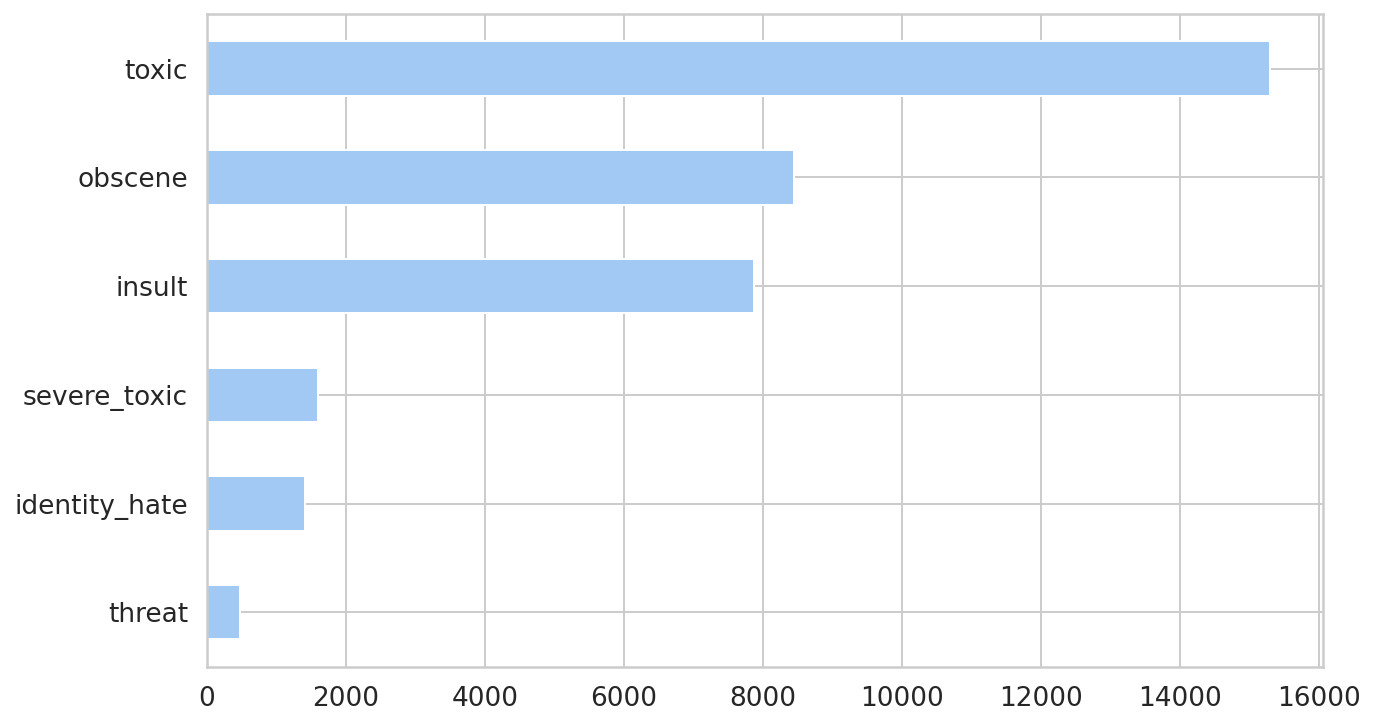

In [25]:
label_columns = df.columns.to_list()[2:]
print(label_columns)

df[label_columns].sum().sort_values().plot(kind="barh")

### class-imbalance [ toxic vs clean]

(15439, 8)


<AxesSubplot:>

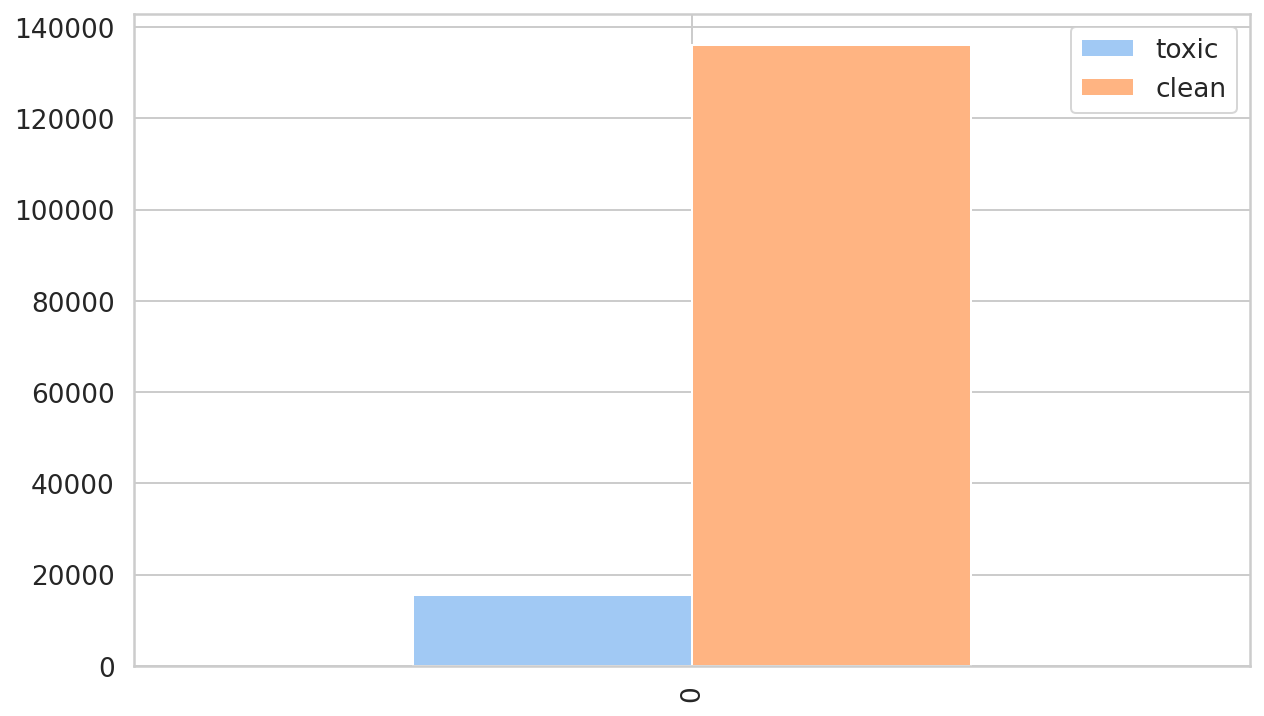

In [30]:
train_toxic = train_df[train_df[label_columns].sum(axis=1) > 0]
train_clean = train_df[train_df[label_columns].sum(axis=1) == 0]

print(train_toxic.shape)

pd.DataFrame(dict(toxic = [len(train_toxic)], clean = [len(train_clean)])).plot(kind="bar")


In [35]:
train_df = pd.concat([ train_toxic,  train_clean.sample(15_000)])
print(train_df.shape, dev_df.shape)


(30439, 8) (7979, 8)


## Tokenization

In [57]:
BERT_MODEL_NAME = 'bert-base-cased'
MAX_TOKEN_COUNT = 512

tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [58]:
# sample
sample_row = df.iloc[16]
sample_comment = sample_row.comment_text
sample_labels = sample_row[label_columns]

print(sample_labels.to_dict())

{'toxic': 1, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}


In [59]:
# encoding

encoding = tokenizer.encode_plus( sample_comment
                                , add_special_tokens=True
                                , max_length=512
                                , return_token_type_ids=False
                                , padding="max_length"
                                , return_attention_mask=True
                                , return_tensors='pt'
                                , )

print(encoding.keys())
encoding["input_ids"].shape, encoding["attention_mask"].shape

dict_keys(['input_ids', 'attention_mask'])


(torch.Size([1, 512]), torch.Size([1, 512]))

In [60]:
print(f"""
Input ids:
{encoding["input_ids"].squeeze()[:20]}

Attention masks:
{encoding["attention_mask"].squeeze()[:20]}
""")


Input ids:
tensor([  101, 17774,   106,  1790,   112,   189,  1440,   117,  1435,  1137,
         1341,  1104,  3254,  5031,  1171,   106,  1706, 14607,   119,   102])

Attention masks:
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])



In [61]:
# inverse tokenization ( words from token_ids )
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:20])

['[CLS]', 'Bye', '!', 'Don', "'", 't', 'look', ',', 'come', 'or', 'think', 'of', 'com', '##ming', 'back', '!', 'To', '##sser', '.', '[SEP]']


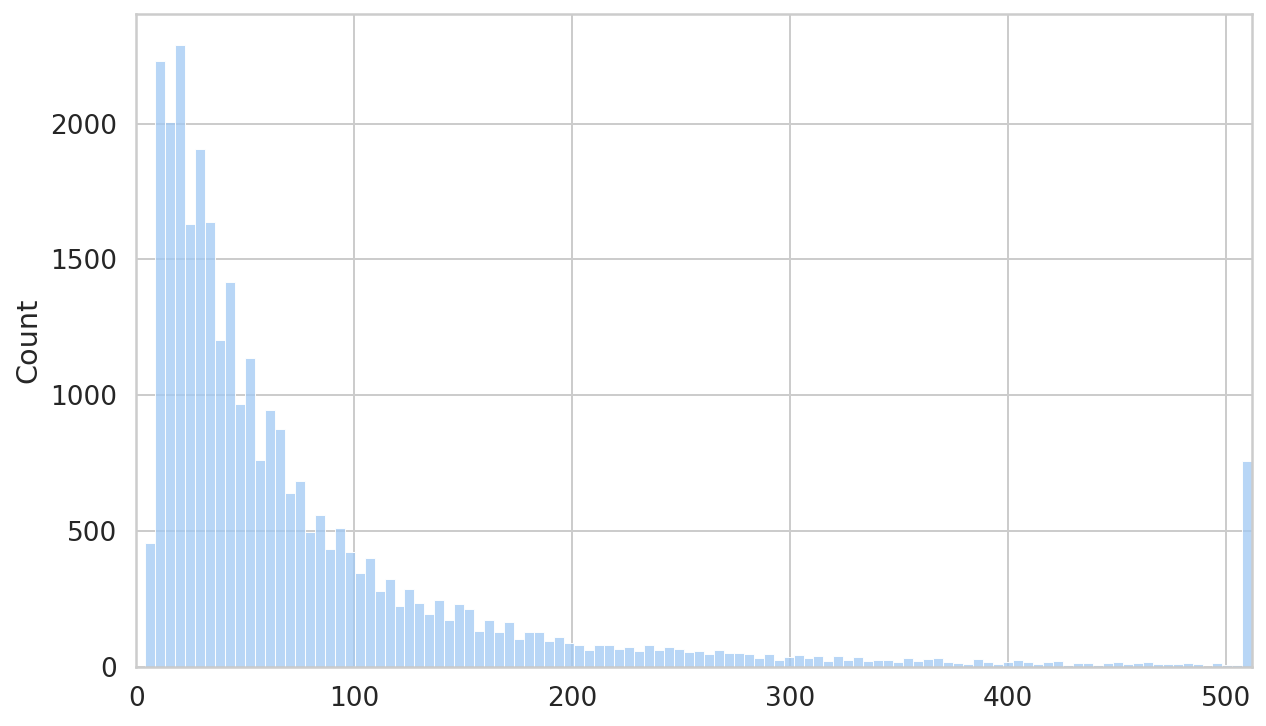

In [62]:
# token count per comment
token_counts = []

for _, row in train_df.iterrows():
    tokens = tokenizer.encode(row["comment_text"], max_length=512, truncation=True)
    token_counts.append(len(tokens))

# print(token_counts)

sns.histplot(token_counts)
plt.xlim([0, 512]);

In [65]:
class ToxicCommentsDataset(Dataset):

  def __init__(
    self,
    data: pd.DataFrame,
    tokenizer: BertTokenizer,
    max_token_len: int = 128
  ):

    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):

    data_row = self.data.iloc[index]
    comment_text = data_row.comment_text
    labels = data_row[label_columns]

    encoding = self.tokenizer.encode_plus(

      comment_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',

    )

    return dict(
      comment_text=comment_text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels) )

In [86]:
train_dataset = ToxicCommentsDataset(train_df, tokenizer, max_token_len=MAX_TOKEN_COUNT)
sample_item = train_dataset[1]

print(sample_item.keys())

print(f"""
Shape inputs
{sample_item["input_ids"].shape}

Input ids:
{sample_item["input_ids"][:100]}

Attention mask:
{sample_item["attention_mask"][:100]}

Comment text:
{sample_item["comment_text"][:100]}

Labels:
{sample_item["labels"]}
""")

dict_keys(['comment_text', 'input_ids', 'attention_mask', 'labels'])

Shape inputs
torch.Size([512])

Input ids:
tensor([ 101, 1128, 1132,  170,  185, 7625,  117, 1105, 1139, 7972, 1209, 1129,
        4105,  106, 5871, 2328, 2328, 2328, 2328, 3354, 3354, 3354, 3354, 3354,
        3354, 3354, 3354, 3354, 3354, 3354, 3354, 3354, 3354, 3354, 1161,  119,
         102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])

Attention mask:
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## BERT